In [1]:
# for processing dataset
import numpy as np
import pandas as pd
import re
from math import ceil, floor

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [2]:
df = pd.concat([pd.read_csv('lamudi_house_dataset.csv'), pd.read_csv('lamudi_house_dataset_2.csv')], axis=0)
df = df.drop('Unnamed: 0', axis=1) # from the creation of csv
df.head()

,data_price_s,data_category_s,data_subcategories_s,data_bedrooms_s,data_bathrooms_s,data_building_size_s,data_land_size_s,data_furnished_s,data_sku_s,data_geo_point_s,page_link_s,parent_link_s
0,2.000000e+08,house,"[""house"",""single-family-house""]",2,2.0,52.0,40.0,NaN,HO63342840B9EB3ID,NaN,https://www.lamudi.co.id/wujudkan-dan-desain-h...,https://www.lamudi.co.id/jakarta/kepulauan-ser...
1,1.250000e+09,house,"[""house"",""single-family-house""]",3,2.0,200.0,200.0,NaN,HO63CE42B5E3B0AID,NaN,https://www.lamudi.co.id/rumah-kedungmundu-mur...,https://www.lamudi.co.id/jakarta/kepulauan-ser...
2,6.910000e+08,house,"[""house"",""single-family-house""]",2,2.0,55.0,60.0,NaN,HO62B162B0CB941ID,NaN,https://www.lamudi.co.id/rumah-2-lt-hot-promo-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...
3,1.200000e+09,house,"[""house"",""single-family-house""]",3,1.0,80.0,150.0,NaN,HO5E2567A098B1DID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-siap-huni-luas-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...
4,2.100000e+09,house,"[""house"",""single-family-house""]",6,2.0,150.0,305.0,NaN,HO60111E9AC8A8EID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-siap-huni-luas-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...


## Target

Let's see the distribution of the target variable's distribution

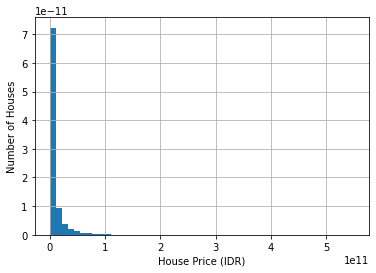

In [3]:
df['data_price_s'].hist(bins=50, density=True)
plt.ylabel('Number of Houses')
plt.xlabel('House Price (IDR)')
plt.show()

We can see that the distribution is skewed to the right.

Therefore, we are going to improve the distribution by logarithmic transformation

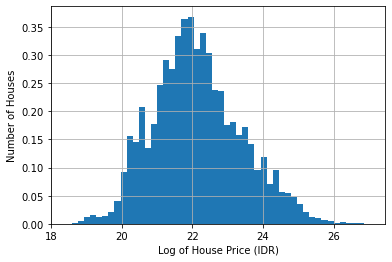

In [4]:
np.log(df['data_price_s']).hist(bins=50, density=True)
plt.ylabel('Number of Houses')
plt.xlabel('Log of House Price (IDR)')
plt.show()

We can see that the distribution is less skewed and more Gaussian (qualitatively seen)

This is good because there will be a data generalization problem if those tails are sparsely populated dominated the prediction error

In [5]:
df['data_price_s'] = np.log(df['data_price_s'])

## Variable Types

Next, we are going to identify the numerical and categorical variables

### Categorical Variables

In [6]:
df.columns

Index(['data_price_s', 'data_category_s', 'data_subcategories_s',
       'data_bedrooms_s', 'data_bathrooms_s', 'data_building_size_s',
       'data_land_size_s', 'data_furnished_s', 'data_sku_s',
       'data_geo_point_s', 'page_link_s', 'parent_link_s'],
      dtype='object')

In [7]:
cat_vars = [var for var in df.columns if df[var].dtype == 'O']
cat_vars

['data_category_s',
 'data_subcategories_s',
 'data_furnished_s',
 'data_sku_s',
 'data_geo_point_s',
 'page_link_s',
 'parent_link_s']

In [8]:
df[cat_vars].head()

,data_category_s,data_subcategories_s,data_furnished_s,data_sku_s,data_geo_point_s,page_link_s,parent_link_s
0,house,"[""house"",""single-family-house""]",NaN,HO63342840B9EB3ID,NaN,https://www.lamudi.co.id/wujudkan-dan-desain-h...,https://www.lamudi.co.id/jakarta/kepulauan-ser...
1,house,"[""house"",""single-family-house""]",NaN,HO63CE42B5E3B0AID,NaN,https://www.lamudi.co.id/rumah-kedungmundu-mur...,https://www.lamudi.co.id/jakarta/kepulauan-ser...
2,house,"[""house"",""single-family-house""]",NaN,HO62B162B0CB941ID,NaN,https://www.lamudi.co.id/rumah-2-lt-hot-promo-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...
3,house,"[""house"",""single-family-house""]",NaN,HO5E2567A098B1DID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-siap-huni-luas-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...
4,house,"[""house"",""single-family-house""]",NaN,HO60111E9AC8A8EID,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-siap-huni-luas-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...


Let's make hypothesis about the columns:
1. `data_category_s`: Should be 'house' only, I guess
2. `data_subcategories_s`: Should subcategories that can further distinguish the type of the properties being sold
3. `data_furnished_s`: Should contain the information whether the house is furnished or not
4. `data_sku_s`: Should be the 'Stock Keeping Unit' (SKU) or identifier of the houses
5. `data_geo_point_s`: Should contain the 'Longitude' and 'Latitude' pair. This is the most general information and we can do a lot of things with this particular pair
6. `page_link_s`: Should be the link to the detailed information of the houses
7. `parent_link_s`: From my scraper code, this is the parent link for the houses, should contain _Kecamatan_ information

We have `data_category_s`, let's see if there are any information in the column

In [9]:
df['data_category_s'].value_counts()

house    79140
Name: data_category_s, dtype: int64

Though it is quite assuring that all of our data is considered a house, it is a constant variable. So, let's drop it

In [10]:
df = df.drop('data_category_s', axis=1)

Since we have the `data_sku_s`, let's do a sanity check and see if there are duplicates

In [11]:
print('Number of rows:', len(df))
print('Number of unique SKUs:', len(df['data_sku_s'].unique()))

Number of rows: 79140
Number of unique SKUs: 75812


In [12]:
df['data_sku_s'].value_counts().sort_values(ascending=False).head()

HO62187E3FD754CID    3
HO643ED0D32EEE2ID    3
HO62060678D0D5FID    3
HO5F9A51377CEBAID    3
HO6421B405679B7ID    3
Name: data_sku_s, dtype: int64

In [13]:
sample_duplicate_skus = df['data_sku_s'].value_counts().sort_values(ascending=False).head().index
df[ df['data_sku_s'].isin(sample_duplicate_skus) ].sort_values('data_sku_s').head()

,data_price_s,data_subcategories_s,data_bedrooms_s,data_bathrooms_s,data_building_size_s,data_land_size_s,data_furnished_s,data_sku_s,data_geo_point_s,page_link_s,parent_link_s
2112,23.723986,"[""house"",""boarding-house""]",26,28.0,660.0,477.0,NaN,HO5F9A51377CEBAID,"[106.807896,-6.176647]",https://www.lamudi.co.id/rumah-kosan-dan-offic...,https://www.lamudi.co.id/jakarta/jakarta-barat...
2130,23.723986,"[""house"",""boarding-house""]",26,28.0,660.0,477.0,NaN,HO5F9A51377CEBAID,"[106.807896,-6.176647]",https://www.lamudi.co.id/rumah-kosan-dan-offic...,https://www.lamudi.co.id/jakarta/jakarta-barat...
2390,23.723986,"[""house"",""boarding-house""]",26,28.0,660.0,477.0,NaN,HO5F9A51377CEBAID,"[106.807896,-6.176647]",https://www.lamudi.co.id/rumah-kosan-dan-offic...,https://www.lamudi.co.id/jakarta/jakarta-barat...
15506,24.730599,"[""house"",""single-family-house""]",4,4.0,425.0,1046.0,NaN,HO62060678D0D5FID,"[106.825844,-6.225614]",https://www.lamudi.co.id/rumah-patra-kuningan-...,https://www.lamudi.co.id/jakarta/jakarta-selat...
15522,24.730599,"[""house"",""single-family-house""]",4,4.0,425.0,1046.0,NaN,HO62060678D0D5FID,"[106.825844,-6.225614]",https://www.lamudi.co.id/rumah-patra-kuningan-...,https://www.lamudi.co.id/jakarta/jakarta-selat...


The duplication of data may be caused by different pages loading the same house. Therefore, we need to clean it before doing any analysis

In [14]:
df = df.drop_duplicates('data_sku_s', keep='first').reset_index(drop=True)
print('Number of rows after dropping duplicate rows:', len(df))

Number of rows after dropping duplicate rows: 75812


Now, let's drop the SKU (identifier)

In [15]:
df = df.drop('data_sku_s', axis=1)

### Numerical Variables

In [16]:
num_vars = [var for var in df.columns if df[var].dtype != 'O']
num_vars

['data_price_s',
 'data_bedrooms_s',
 'data_bathrooms_s',
 'data_building_size_s',
 'data_land_size_s']

In [17]:
df[num_vars].head()

,data_price_s,data_bedrooms_s,data_bathrooms_s,data_building_size_s,data_land_size_s
0,19.113828,2,2.0,52.0,40.0
1,20.946409,3,2.0,200.0,200.0
2,20.353650,2,2.0,55.0,60.0
3,20.905587,3,1.0,80.0,150.0
4,21.465203,6,2.0,150.0,305.0


Let's make hypothesis about the columns:
1. `data_price_s`: Should be the selling price in Lamudi website
2. `data_bedroom_s`: Should be the number of bedrooms in the house
3. `data_bathroom_s`: Should be the number of bathrooms in the house. Curiously, it is rendered in Python as float
4. `data_building_size_s`: Should be the building size in unit $m^2$
4. `data_land_size_s`: Should be the land size in unit $m^2$

Since we have float values for `data_bathrooms_s`, let's do a sanity check

In [18]:
df['data_bathrooms_s'].unique()

array([  2. ,   1. ,   4. ,   3. ,   7. ,   5. ,  21. ,   8. ,   9. ,
         6. ,  13. ,  20. ,  16. ,  11. ,  10. ,  18. ,  12. ,  32. ,
        14. ,  28. ,  29. ,  19. ,   0. ,  44. ,  30. ,  40. ,  23. ,
        26. ,  22. ,  39. ,  17. ,  15. ,  33. ,  65. ,  25. ,  42. ,
        37. ,  54. ,  34. ,  31. ,  36. ,  35. ,  55. ,  60. ,  72. ,
        50. ,  27. ,  24. ,  68. ,  76. ,  58. ,  56. ,  43. ,  45. ,
        49. ,  81. , 106. ,  38. ,  41. ,  70. ,  64. ,  63. , 103. ,
        62. ,  67. ,  83. ,  47. ,  46. ,  52. , 160. , 186. ,  61. ,
        80. ,  69. ,  51. ,  89. , 105. , 104. , 110. , 141. ,   1.5,
       324. , 102. ])

Curiously, there is at least one house with 1.5 bathrooms. Usually, in Indonesia, people will write $n+1$ bathrooms to indicate that there are $n$ bathrooms for the owner and $1$ bathroom for the maid. I guess it is the same case with this. I guess the seller wanted to indicate that there is one bathroom for the owner and one bathroom for the maid. It is more reasonable to round the values to integer

In [19]:
df['data_bathrooms_s'] = round(df['data_bathrooms_s']).astype(int)

## Missing Values

Now we are going to decide what to do with the missing values, if any

In [20]:
df.isna().sum()

data_price_s                1
data_subcategories_s        0
data_bedrooms_s             0
data_bathrooms_s            0
data_building_size_s        0
data_land_size_s            0
data_furnished_s        74853
data_geo_point_s        14375
page_link_s                 0
parent_link_s               0
dtype: int64

There are 3 columns with missing values:
1. `data_price_s`: Since only one row is missing, it is better to drop this row. Since it will be our mandatory target
2. `data_furnished_s`: There are many missing values for this column. We are going to drop the column instead
3. `data_geo_point_s`: This is a hard decision, but what I had in mind was to create a model that uses this particular information alongside data from external sources. Therefore, I will remove all rows with missing geo point

In [21]:
df = df[ ~df['data_price_s'].isna() ].reset_index(drop=True)

In [22]:
df = df[ ~df['data_geo_point_s'].isna() ].reset_index(drop=True)

In [23]:
df.isna().sum()

data_price_s                0
data_subcategories_s        0
data_bedrooms_s             0
data_bathrooms_s            0
data_building_size_s        0
data_land_size_s            0
data_furnished_s        60480
data_geo_point_s            0
page_link_s                 0
parent_link_s               0
dtype: int64

In [24]:
df = df.drop('data_furnished_s', axis=1)

let's update our `cat_vars` and `num_vars` variables

In [25]:
cat_vars = [var for var in df.columns if df[var].dtype == 'O']
num_vars = [var for var in df.columns if df[var].dtype != 'O']

In [26]:
df.head()

,data_price_s,data_subcategories_s,data_bedrooms_s,data_bathrooms_s,data_building_size_s,data_land_size_s,data_geo_point_s,page_link_s,parent_link_s
0,20.905587,"[""house"",""single-family-house""]",3,1,80.0,150.0,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-siap-huni-luas-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...
1,21.465203,"[""house"",""single-family-house""]",6,2,150.0,305.0,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-siap-huni-luas-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...
2,22.084242,"[""house"",""single-family-house""]",5,4,176.0,435.0,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-hoek-siap-huni-...,https://www.lamudi.co.id/jakarta/kepulauan-ser...
3,22.227343,"[""house"",""single-family-house""]",4,2,264.0,310.0,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-2lt-siap-huni-l...,https://www.lamudi.co.id/jakarta/kepulauan-ser...
4,21.635147,"[""house"",""single-family-house""]",5,3,300.0,184.0,"[106.95499,-6.19651]",https://www.lamudi.co.id/rumah-2-lantai-luas-1...,https://www.lamudi.co.id/jakarta/kepulauan-ser...


## Removing Outliers and Dataset Scoping

In [27]:
df.describe()

,data_price_s,data_bedrooms_s,data_bathrooms_s,data_building_size_s,data_land_size_s
count,61436.000000,61436.000000,61436.000000,61436.000000,6.143600e+04
mean,22.228189,4.642913,3.755827,324.988449,4.786080e+04
std,1.220210,6.145222,4.499341,2565.031415,9.590175e+06
min,18.420681,0.000000,0.000000,0.000000,0.000000e+00
25%,21.391095,3.000000,2.000000,120.000000,9.200000e+01
50%,22.109560,4.000000,3.000000,210.000000,1.600000e+02
75%,22.974558,5.000000,4.000000,400.000000,3.200000e+02
max,27.033184,425.000000,324.000000,450000.000000,2.300000e+09


We can see that there are rows with 0 bedrooms or 0 bathrooms or 0 sizes. This is not within our scope. Let's set minimum values for each columns

In [28]:
min_bathroom_s = 1
min_bedroom_s = 1
min_building_size_s = 6 # I guess 6 meters-squared is already a valid size
min_land_size_s = 6 # The same with land size

In [29]:
df = df[ df['data_bathrooms_s'] >= min_bathroom_s ]
df = df[ df['data_bedrooms_s'] >= min_bedroom_s ]
df = df[ df['data_building_size_s'] >= min_building_size_s ]
df = df[ df['data_land_size_s'] >= min_land_size_s ]
df = df.reset_index(drop=True)

Also, we can see that there are maximum value anomalies in the bathrooms, bedrooms, building sizes, and land sizes.

We also need to filter those. Let's remove all irrelevant values.

We need to revisit our goal. That is, to get the prices of general houses. Therefore, we'll filter all values more than 99th percentile for those variables

In [30]:
max_bathroom_s = np.percentile(df['data_bathrooms_s'], 99)
max_bedroom_s = np.percentile(df['data_bedrooms_s'], 99)
max_building_size_s = np.percentile(df['data_building_size_s'], 99)
max_land_size_s = np.percentile(df['data_land_size_s'], 99)

In [31]:
df = df[ df['data_bathrooms_s'] <= max_bathroom_s ]
df = df[ df['data_bedrooms_s'] <= max_bedroom_s ]
df = df[ df['data_building_size_s'] <= max_building_size_s ]
df = df[ df['data_land_size_s'] <= max_land_size_s ]
df = df.reset_index(drop=True)

## Let's save the Cleaned Dataset

In [32]:
df.to_csv('lamudi_house_dataset_cleaned.csv')

## Processing Subcategories

In [33]:
df['data_subcategories_s'].unique()

array(['["house","single-family-house"]', '["house","townhouse"]',
       '["house","boarding-house"]', '["house","subsidized-house"]',
       '[null,"house","single-family-house"]', '["house","villa"]',
       '[null,"house","townhouse"]', '[null,"house"]',
       '[null,"house","boarding-house"]'], dtype=object)

In [34]:
print('Number of data:', len(df))
print('Number of data with houses category', len(df[ df['data_subcategories_s'].str.contains('"house"') ])) # as expected

Number of data: 58973
Number of data with houses category 58973


In [35]:
# processing array columns
subcategories = set({})
for str_arr in df['data_subcategories_s'].unique():
    arr = eval(str_arr.replace('null,', ''))
    for subcategory in arr:
        subcategories.add(subcategory)
print(subcategories)

{'villa', 'townhouse', 'subsidized-house', 'house', 'boarding-house', 'single-family-house'}


In [36]:
# let's define a function to analyze data subcategories
def analyze_array_columns(df, col, target):
    df = df.copy(deep=True)
    subcategories = set({})
    for str_arr in df[col].unique():
        arr = eval(str_arr.replace('null,', ''))
        for subcategory in arr:
            subcategories.add(subcategory)
    for subcategory in subcategories:
        df[subcategory] = df[col].str.contains('"'+subcategory+'"')
        tmp = df.groupby(subcategory)[target].agg(['mean', 'std'])
        tmp.plot(kind="barh", y="mean", legend=False
                 , xerr="std", title="House Price", color='green')

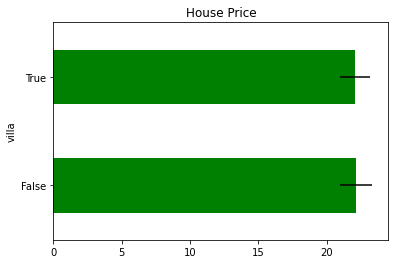

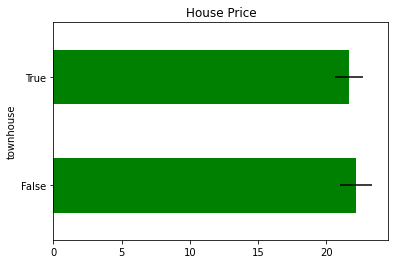

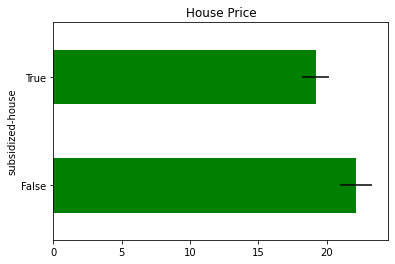

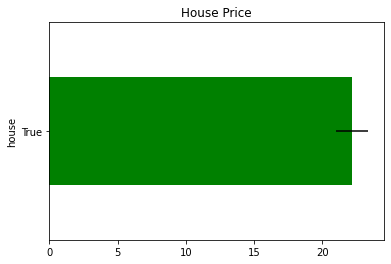

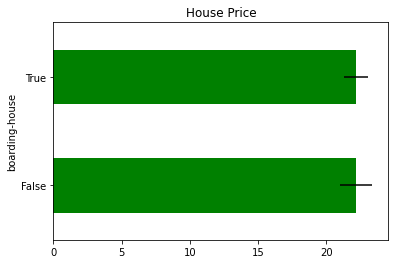

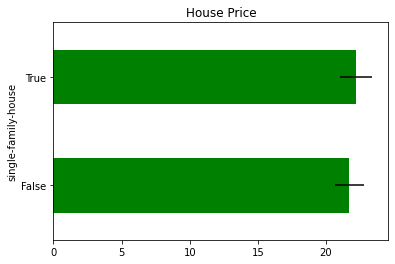

In [37]:
analyze_array_columns(df, 'data_subcategories_s', 'data_price_s')

We can see, as the name suggested, that subsidized house are sold in lower price than non-subsidized house

It is quite surprising that Villas are not that expensive compared to normal houses

## Processing Kecamatan

In [38]:
df['parent_link_s'].unique()[:5]

array(['https://www.lamudi.co.id/jakarta/kepulauan-seribu/kepulauan-seribu-utara/house/buy/',
       'https://www.lamudi.co.id/jakarta/kepulauan-seribu/pulau-tidung/house/buy/',
       'https://www.lamudi.co.id/jakarta/jakarta-selatan/jagakarsa/house/buy/',
       'https://www.lamudi.co.id/jakarta/jakarta-selatan/kebayoran-baru/house/buy/',
       'https://www.lamudi.co.id/jakarta/jakarta-selatan/cilandak/house/buy/'],
      dtype=object)

We can see that there are _Kabupaten_ and _Kecamatan_ information in the `parent_link`. Let's check if there are any useful information

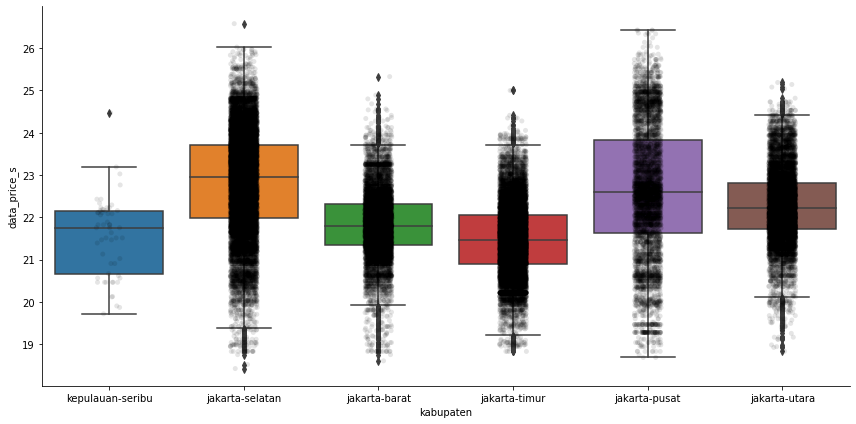

In [39]:
kabupaten_pattern = r'([-\w]+)/([-\w]+)/house/buy/$'
df['kabupaten'] = df['parent_link_s'].apply(lambda x: re.search(kabupaten_pattern, x)[1])
sns.catplot(x='kabupaten', y='data_price_s', data=df, kind="box", height=6, aspect=2)
sns.stripplot(x='kabupaten', y='data_price_s', data=df, jitter=0.1, alpha=0.1, color='k')
plt.show()

Let's go down to _Kecamatan_ level

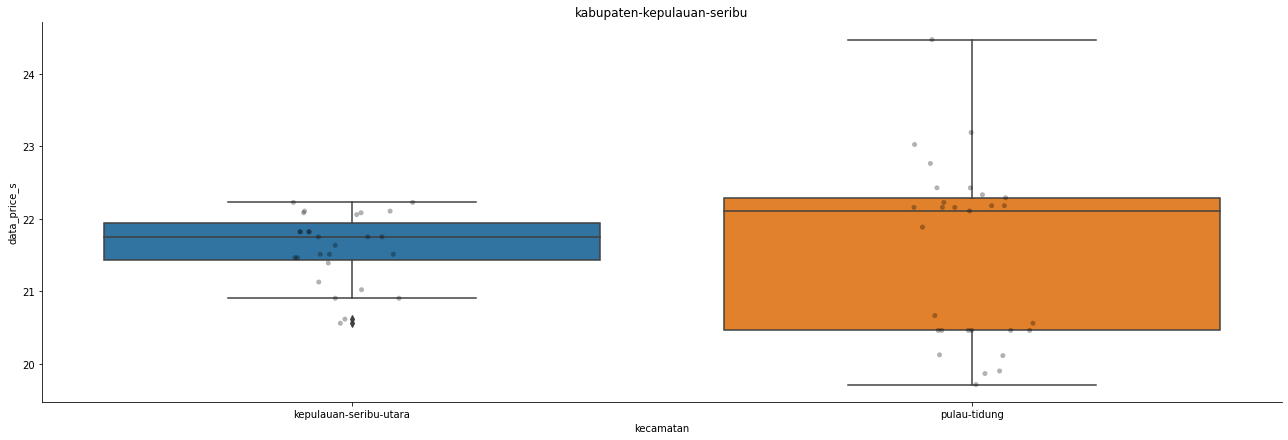

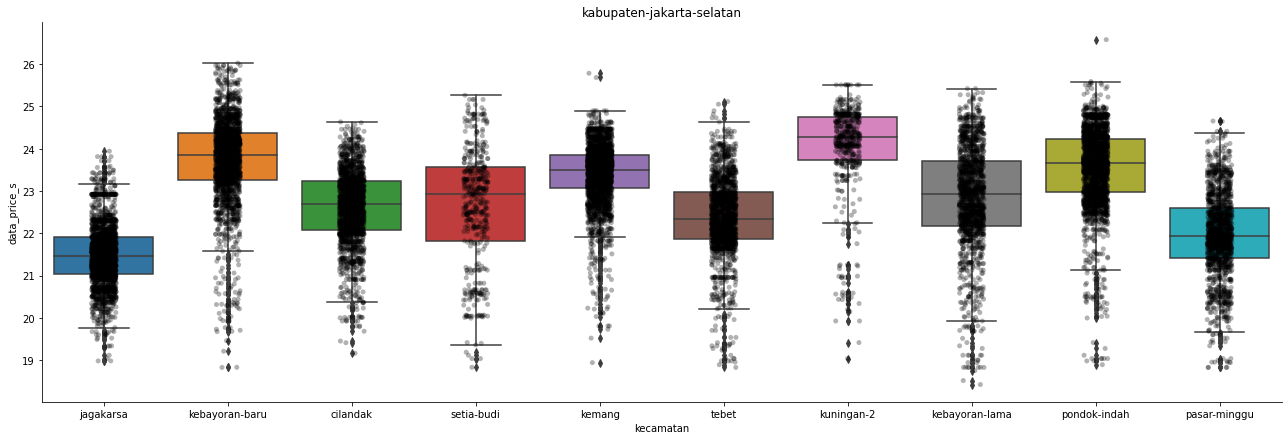

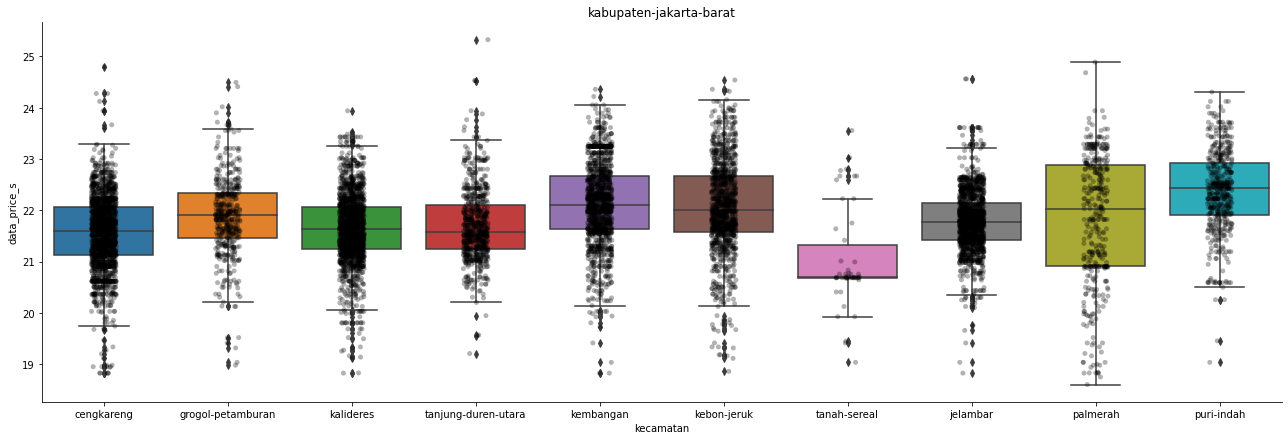

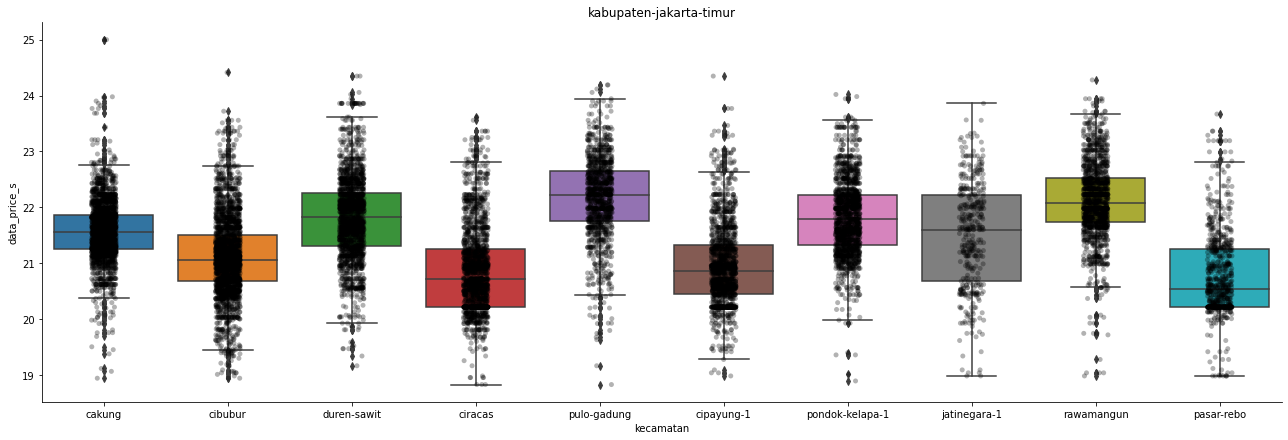

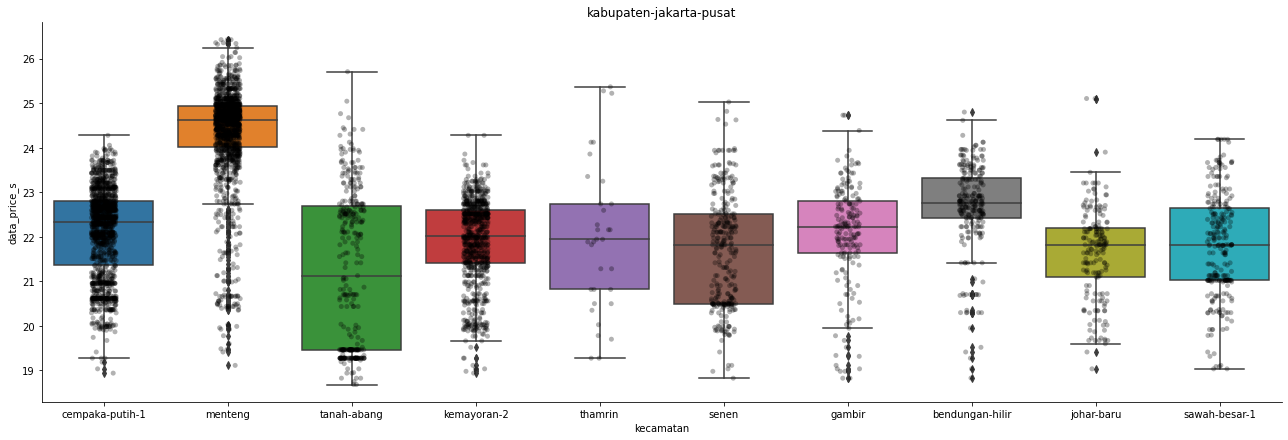

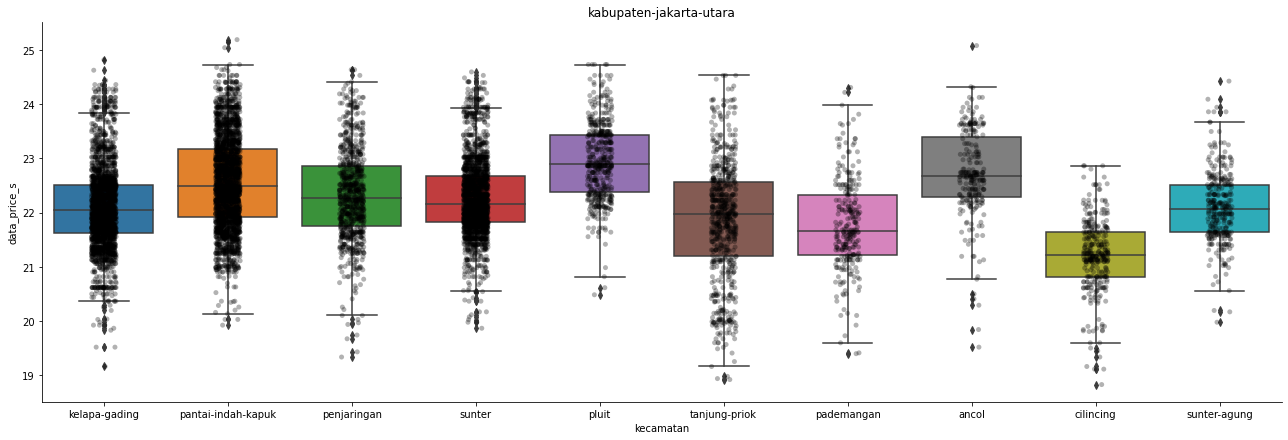

In [40]:
kecamatan_pattern = r'/([-\w]+)/house/buy/$'
df['kecamatan'] = df['parent_link_s'].apply(lambda x: re.search(kecamatan_pattern, x)[1])
for kabupaten in df['kabupaten'].unique():
    sns.catplot(x='kecamatan', y='data_price_s', data=df[df['kabupaten']==kabupaten], kind="box", height=6, aspect=3)
    sns.stripplot(x='kecamatan', y='data_price_s', data=df[df['kabupaten']==kabupaten], jitter=0.1, alpha=0.3, color='k')
    plt.title('kabupaten-'+kabupaten)
    plt.show()

Certainly, knowing the _Kecamatan_ will help anybody to determine price. One clearest example is for _Tanah Abang_ compared ti _Menting_ in _Jakarta Barat_

## Processing Floors

We will now see whether having more floors will have influence to the house price

According to the theory, there is a certain rule to know whether a house has more than one floor or not. That is, by comparing `data_building_size_s` to `data_land_size_s`. If `data_building_size_s` is greater than `data_land_size_s`, it is certain that there are more than one floor in the house

In [41]:
df['floor_by_size'] = np.vectorize(ceil)(df['data_building_size_s']/df['data_land_size_s'])

On the other hand, there is another method. That is, by looking at the `page_link_s`. Some included the floor number in the description. Let's take a look at the links

In [42]:
df['page_link_s'].head(20).unique()

array(['https://www.lamudi.co.id/rumah-siap-huni-luas-10x15-type-3kt-di-pulogebang-permai-cakung-jakarta-timur-4.html',
       'https://www.lamudi.co.id/rumah-siap-huni-luas-15x20-type-6-1kt-di-pulogebang-permai-cakung-jakarta-timur.html',
       'https://www.lamudi.co.id/rumah-hoek-siap-huni-luas-17x25-type-5kt-pulogebang-permai-cakung-jakarta-timur.html',
       'https://www.lamudi.co.id/rumah-2lt-siap-huni-luas-12x25-type-4kt-pulogebang-permai-cakung-jakarta-timur.html',
       'https://www.lamudi.co.id/rumah-2-lantai-luas-12x15-3-type-5kt-uf-pulo-gebang-permai-cakung-jakarta-timur-6.html',
       'https://www.lamudi.co.id/jual-rumah-1-lantai-siap-huni-di-pulogebang-permai-ujung-menteng-jakarta-timur.html',
       'https://www.lamudi.co.id/rumah-3lantai-luas-8x25-200m-type-4kt-pulogebang-p-168188074389.html',
       'https://www.lamudi.co.id/rumah-hoek-siap-huni-luas-15x15m-type-3kt-di-pulog-168191815281.html',
       'https://www.lamudi.co.id/rumah-hoek-siap-huni-luas-15x15m-type-3

Floor in Indonesian is _lantai_, and some people abbreviated it to _lt_. According to the grammar, we should include the number before we mention the things, _e.g._, _3 lantai_ means 3 floors.

In [43]:
floor_pattern = '(\d+).?(lantai|lt)'
df['floor_pattern'] = df['page_link_s'].apply(lambda x: re.search(floor_pattern, x)[1] if re.search(floor_pattern, x) else 0).astype(int)

In [44]:
# let's take a look at some mapped floors using this method
for link, floor_by_pattern in zip(df[ df['floor_pattern']!=0 ].sort_values('floor_pattern', ascending=False)['page_link_s'].head(30)
                                , df[ df['floor_pattern']!=0 ].sort_values('floor_pattern', ascending=False)['floor_pattern'].head(30)):
    print(link, ':', floor_by_pattern)

https://www.lamudi.co.id/rumah-minimalis-renov-2019-lantai-granit-hanya-10-mnt-gto-bukit-golf-cibubur.html : 2019
https://www.lamudi.co.id/jual-rumah-mewah-4-8m-masih-baru-lb-250-lt-178m-ad-167480367069.html : 250
https://www.lamudi.co.id/rumah-di-pondok-kelapa-lb-180lt-104-dgn-2-lantai.html : 180
https://www.lamudi.co.id/anarumah-uk-4x25m-3-75lt-cocok-hunian-usaha-lokasi-168190995785.html : 75
https://www.lamudi.co.id/ana-rumah-3-75-lantai-uk-5-5x15m-jalan-mobil-di-ta-166030157889.html : 75
https://www.lamudi.co.id/ana-rumah-uk-4x25m-3-75lt-cocok-hunian-usaha-lokasi-nyaman-jelambar.html : 75
https://www.lamudi.co.id/chandra-rumah-3-75-lantai-uk-7x13m-bangunan-bagus-165848481232.html : 75
https://www.lamudi.co.id/rumah-uk-4x25m-3-75lt-cocok-hunian-usaha-lokasi-nyaman-jelambar.html : 75
https://www.lamudi.co.id/rumah-baru-di-pondok-indah-35-lantai-bangunan-baru-dan-besar-full-marmer-1092524.html : 35
https://www.lamudi.co.id/rumah-mewah-layar-permai-termurah-12x27-lantai-marmer-full-fur

When we look at the parsed data, we find that many floors are mapped the wrong way because:
1. They use _lt_ as _luas tanah_ that can mean land size in Indonesian
2. The number of floors are actually floating numbers such as 2.25 or 2.5 floors

Though it is tempting to just skip it altogether, getting precise `floor` is still valuable. So, we'll just limit the values to 4 floors

In [45]:
# as we can see, not everyone included the information in the page link
len(df[ (df['floor_pattern']!=0) & (df['floor_pattern']<5) ][['page_link_s', 'floor_pattern']])

9384

Now, we are going to determine the `floor` by using hierarchical logic:
1. If `floor_pattern` exist (not 0 and less than 5 according to previous logic), we are going to use the column
2. Else, we will use `floor_by_size`

In the real world, we won't get ambiguous floor information. That's why we only need one column for `floor`

In [46]:
def get_floor(floor_pattern, floor_by_size):
    if floor_pattern != 0 and floor_pattern < 5:
        return floor_pattern
    else:
        return floor_by_size

In [47]:
df['floor'] = np.vectorize(get_floor)(df['floor_pattern'], df['floor_by_size'])
df = df.drop(['floor_pattern','floor_by_size'], axis=1)

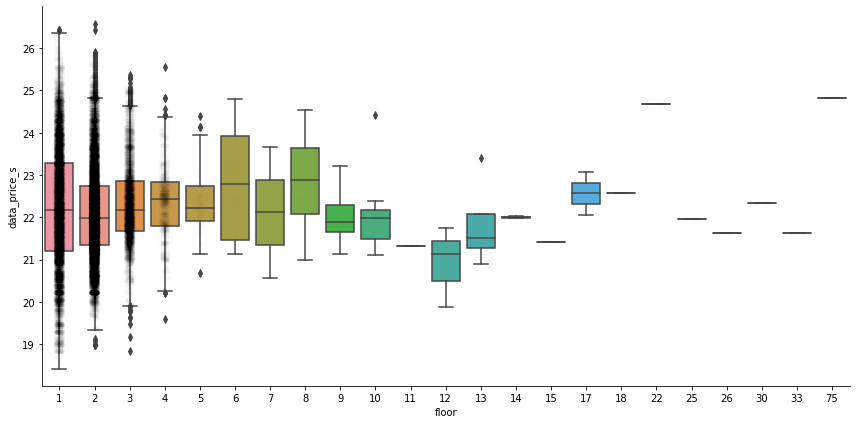

In [48]:
sns.catplot(x='floor', y='data_price_s', data=df, kind="box", height=6, aspect=2)
sns.stripplot(x='floor', y='data_price_s', data=df, jitter=0.1, alpha=0.01, color='k')
plt.show()

Though the information seems ambiguous, the baseline for houses with more than one floor is higher than those house with only one floor.

Also, there are many floors with rare values. We are going to deal with that later

## Discrete Numerical Variables

In [49]:
discrete_num_vars = [var for var in num_vars if df[var].nunique() < 30]

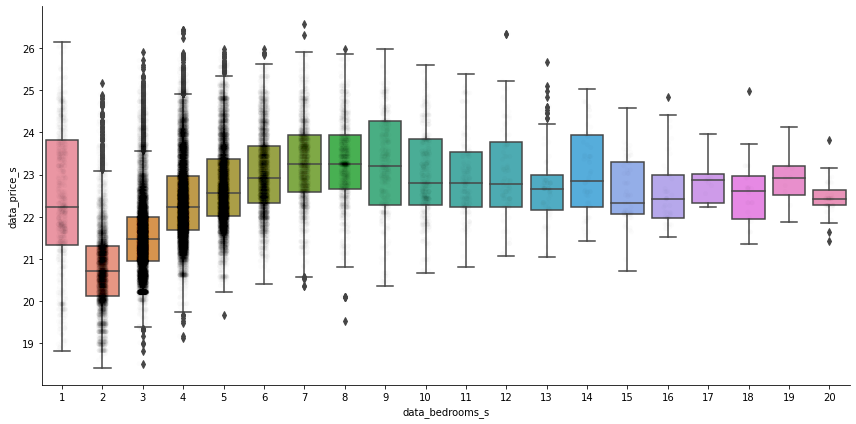

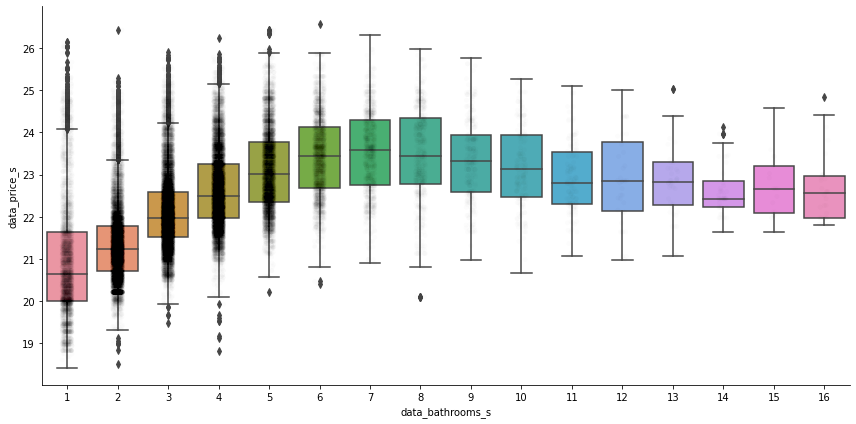

In [50]:
for var in discrete_num_vars:
    sns.catplot(x=var, y='data_price_s', data=df, kind="box", height=6, aspect=2)
    sns.stripplot(x=var, y='data_price_s', data=df, jitter=0.1, alpha=0.01, color='k')
    plt.show()

We can see that there are differences in the sales price as the number of bedrooms and bathrooms vary

## Continuous Numerical Variables

In [51]:
cont_num_vars = [var for var in num_vars if var not in discrete_num_vars]

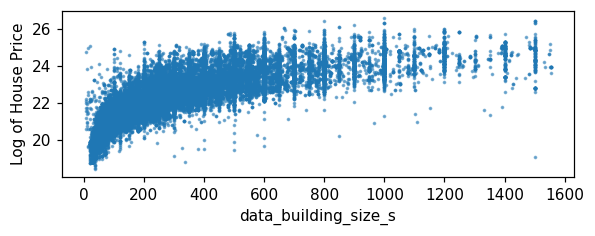

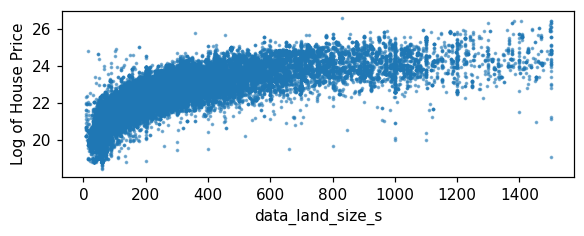

In [52]:
for var in cont_num_vars:
    if var != 'data_price_s':
        plt.figure(figsize=(6,2), dpi=110)
        plt.scatter(df[var], df['data_price_s'], alpha=0.5, s=2)
        plt.ylabel('Log of House Price')
        plt.xlabel(var)
        plt.show()

As expected, generally, the house prices are increasing accordingly with building sizes and land sizes

## Cardinality of Categorical Variables

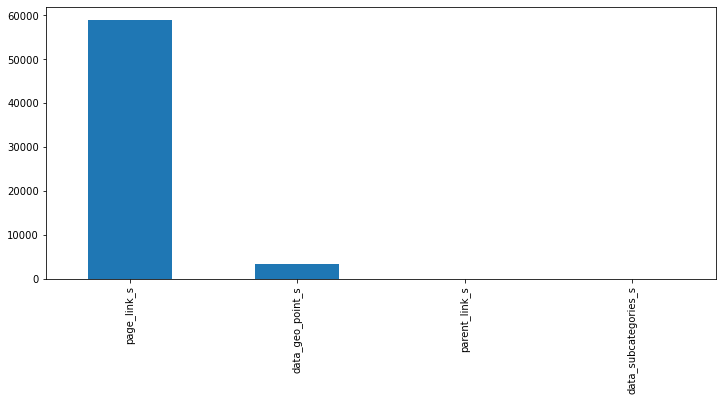

In [53]:
df[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))
plt.show()

We must drop the `page_link_s` and `parent_link_s` since we already harness the data from that column

In [54]:
df = df.drop(['page_link_s', 'parent_link_s'], axis=1)

In [55]:
cat_vars = [var for var in df.columns if df[var].dtype == 'O']

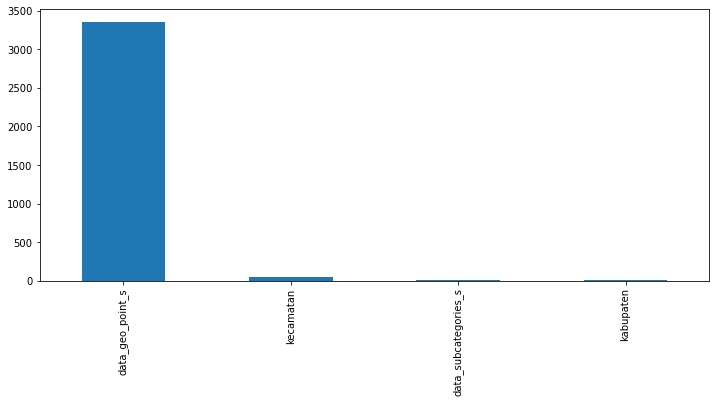

In [56]:
df[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))
plt.show()

We are going to use the `data_geo_point_s` when we are going to join the data to external data sources. So, we are going to leave it like this for now

## Rare Labels

In [57]:
non_cont_vars = [var for var in df.columns if var not in cont_num_vars + ['data_price_s']]

In [58]:
len(df)

58973

In [59]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()
    tmp = df.groupby(var)['data_price_s'].count() / len(df)
    return tmp[tmp < rare_perc]

for var in non_cont_vars:
    if var != 'data_geo_point_s':
        print(analyse_rare_labels(df, var, 0.005)) # less than 0.5%
        print()

data_subcategories_s
["house","subsidized-house"]            0.000899
["house","villa"]                       0.000746
[null,"house","boarding-house"]         0.000017
[null,"house","single-family-house"]    0.000899
[null,"house","townhouse"]              0.000034
[null,"house"]                          0.000712
Name: data_price_s, dtype: float64

data_bedrooms_s
11    0.003256
12    0.001764
13    0.001407
14    0.001068
15    0.001136
16    0.000831
17    0.000288
18    0.000475
19    0.000237
20    0.000865
Name: data_price_s, dtype: float64

data_bathrooms_s
9     0.004561
10    0.002747
11    0.002103
12    0.000678
13    0.000746
14    0.000746
15    0.000356
16    0.000509
Name: data_price_s, dtype: float64

kabupaten
kepulauan-seribu    0.00095
Name: data_price_s, dtype: float64

kecamatan
ancol                     0.004307
bendungan-hilir           0.004290
gambir                    0.003171
johar-baru                0.003137
kepulauan-seribu-utara    0.000458
pademangan     

There are some columns with little amount of data that have risk of being under-represented. However, there are no surefire method to handle such cases.

For example, I myself as Jakarta people know that _thamrin_ houses' price can never be the same to _tanah-sereal_'s.

On the other hand, it is probably a wise decision to regard houses 10 floors as the same with houses that have 22 floors

This preliminary analysis will help us to be more cautious before doing any machine learning work